In [42]:
# Load Packages

import scipy.stats as stats
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from math import sqrt
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


# Data Loading

In [43]:
# Read in ADNIMERGE data

ADNIMERGE_PATH = "/Users/michaelhase/Desktop/ADNI_Proj/data/All_Subjects_Tables/ADNIMERGE.csv"
base_volumetric_columns = ["Ventricles", "Hippocampus", "WholeBrain", "Entorhinal", "Fusiform", "MidTemp", "ICV"]

def load_adnimerge(path: str) -> pd.DataFrame:
 
    df = pd.read_csv(path, low_memory=False)
    df = df.dropna(subset=["IMAGEUID", "DX", "DX_bl"])
    df["IMAGEUID"] = df["IMAGEUID"].astype(int)
    df["DX"] = df["DX"].map({"Dementia": "AD", "CN": "CN", "MCI": "MCI"})
    return df

df_adnimerge = load_adnimerge(ADNIMERGE_PATH)

df_patients = df_adnimerge[df_adnimerge["VISCODE"] == "bl"]
anatomical_structures_columns = ["PTID", "AGE", "PTGENDER", "DX"] + base_volumetric_columns
df_patients = df_patients[anatomical_structures_columns]

# Drop rows w/ missing volumetric data
df_patients = df_patients.dropna(subset=base_volumetric_columns)


# Approach 1: ANOVA with Proportionalized ROI Volumes

To account for differences in head size, each ROI was divided by the intracranial volume for each subject to create a proportionalized volume.

In [44]:

grouped_data = df_patients
volumetric_columns = ["Ventricles", "Hippocampus", "WholeBrain", "Entorhinal", "Fusiform", "MidTemp"]

# Create proportionalized volumes
for region in volumetric_columns:
    grouped_data[f'{region}_Prop'] = grouped_data[region] / grouped_data['ICV']

# ANOVA on proportionalized volumes
for region in volumetric_columns:
    model = ols(f'{region}_Prop ~ C(DX)', data=grouped_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA results for {region} (proportionalized):\n", anova_table)

    # Post-hoc test if significant
    if anova_table["PR(>F)"].iloc[0] < 0.05:
        tukey = pairwise_tukeyhsd(endog=grouped_data[f'{region}_Prop'], groups=grouped_data['DX'], alpha=0.05)
        print(f"Tukey HSD results for {region} (proportionalized):\n", tukey)

ANOVA results for Ventricles (proportionalized):
             sum_sq      df         F        PR(>F)
C(DX)     0.021645     2.0  74.57525  6.351604e-32
Residual  0.280090  1930.0       NaN           NaN
Tukey HSD results for Ventricles (proportionalized):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
    AD     CN  -0.0099   0.0 -0.0118  -0.008   True
    AD    MCI  -0.0062   0.0 -0.0081 -0.0044   True
    CN    MCI   0.0037   0.0  0.0023  0.0051   True
---------------------------------------------------
ANOVA results for Hippocampus (proportionalized):
             sum_sq      df           F         PR(>F)
C(DX)     0.000377     2.0  366.509696  1.192822e-135
Residual  0.000993  1930.0         NaN            NaN
Tukey HSD results for Hippocampus (proportionalized):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
-------

# Approach 2: ANCOVA 

This is taking an alternate approach for accounting for variables that could influence ROI volumes. The ANCOVA model takes into account ICV, age, and gender when analyzing ROI volumes.

In [45]:
# ANCOVA model for each brain region, adjusting for ICV, age, and gender
for region in volumetric_columns:
    formula = f'{region} ~ C(DX) + ICV + AGE + PTGENDER'  # Adjust for ICV, age, and gender
    model = ols(formula, data=grouped_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANCOVA results for {region}, adjusted for ICV, Age, and Gender:\n", anova_table)

ANCOVA results for Ventricles, adjusted for ICV, Age, and Gender:
                 sum_sq      df           F         PR(>F)
C(DX)     3.048517e+10     2.0   54.828403   6.952831e-24
PTGENDER  3.774946e+06     1.0    0.013579   9.072466e-01
ICV       1.516477e+11     1.0  545.485101  2.017482e-106
AGE       7.581209e+10     1.0  272.700186   2.152908e-57
Residual  5.348822e+11  1924.0         NaN            NaN
ANCOVA results for Hippocampus, adjusted for ICV, Age, and Gender:
                 sum_sq      df           F         PR(>F)
C(DX)     6.525722e+08     2.0  422.512183  7.707534e-153
PTGENDER  1.596420e+07     1.0   20.672257   5.789225e-06
ICV       7.970242e+07     1.0  103.207722   1.178757e-23
AGE       3.457226e+08     1.0  447.680768   1.667406e-89
Residual  1.485814e+09  1924.0         NaN            NaN
ANCOVA results for WholeBrain, adjusted for ICV, Age, and Gender:
                 sum_sq      df            F         PR(>F)
C(DX)     1.385711e+12     2.0   155.634767

In [46]:
# Post-hoc tests for adjusted volumes after ANCOVA
def run_ancova_posthoc(region, data):
    # Perform ANCOVA for the specified brain region, adjusting for ICV, Age, and Gender
    formula = f'{region} ~ C(DX) + ICV + AGE + PTGENDER'
    model = ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANCOVA results for {region}, adjusted for ICV, Age, and Gender:\n", anova_table)

    # Post-hoc test (Tukey HSD) for group differences after ANCOVA
    tukey = pairwise_tukeyhsd(endog=data[region], groups=data['DX'], alpha=0.05)
    print(f"Tukey HSD results for {region} (adjusted):\n", tukey)

# Run post-hoc tests 
for region in volumetric_columns:
    run_ancova_posthoc(region, grouped_data)

ANCOVA results for Ventricles, adjusted for ICV, Age, and Gender:
                 sum_sq      df           F         PR(>F)
C(DX)     3.048517e+10     2.0   54.828403   6.952831e-24
PTGENDER  3.774946e+06     1.0    0.013579   9.072466e-01
ICV       1.516477e+11     1.0  545.485101  2.017482e-106
AGE       7.581209e+10     1.0  272.700186   2.152908e-57
Residual  5.348822e+11  1924.0         NaN            NaN
Tukey HSD results for Ventricles (adjusted):
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj    lower       upper    reject
--------------------------------------------------------------
    AD     CN -16462.0859   0.0 -19810.3341 -13113.8377   True
    AD    MCI  -9718.4957   0.0 -13006.9596  -6430.0318   True
    CN    MCI   6743.5901   0.0   4296.4882   9190.6921   True
--------------------------------------------------------------
ANCOVA results for Hippocampus, adjusted for ICV, Age, and Gender:
                 sum_sq      df

# Effect Size

In [47]:
# Effect size calculation (Cohen's d for pairwise comparisons)
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = group1.mean(), group2.mean()
    std1, std2 = group1.std(), group2.std()
    pooled_std = sqrt(((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_std

def calculate_cohens_d_for_all_regions(data):
    regions = ["Ventricles", "Hippocampus", "WholeBrain", "Entorhinal", "Fusiform", "MidTemp"]
    for region in regions:
        ad_group = data[data['DX'] == 'AD'][region]
        cn_group = data[data['DX'] == 'CN'][region]
        mci_group = data[data['DX'] == 'MCI'][region]
        
        # Calculate Cohen's d for AD vs CN
        d_ad_cn = cohens_d(ad_group, cn_group)
        print(f"Cohen's d for {region} (AD vs CN): {d_ad_cn}")
        
        # Calculate Cohen's d for AD vs MCI
        d_ad_mci = cohens_d(ad_group, mci_group)
        print(f"Cohen's d for {region} (AD vs MCI): {d_ad_mci}")
        
        # Calculate Cohen's d for CN vs MCI
        d_cn_mci = cohens_d(cn_group, mci_group)
        print(f"Cohen's d for {region} (CN vs MCI): {d_cn_mci}")

# Example: Running Cohen's d for all regions
calculate_cohens_d_for_all_regions(grouped_data)

Cohen's d for Ventricles (AD vs CN): 0.825507857179579
Cohen's d for Ventricles (AD vs MCI): 0.42855381404774845
Cohen's d for Ventricles (CN vs MCI): -0.3298121366091537
Cohen's d for Hippocampus (AD vs CN): -1.9044623238912277
Cohen's d for Hippocampus (AD vs MCI): -0.9958053143786415
Cohen's d for Hippocampus (CN vs MCI): 0.6416957205694748
Cohen's d for WholeBrain (AD vs CN): -0.6091375966475462
Cohen's d for WholeBrain (AD vs MCI): -0.5446965359540119
Cohen's d for WholeBrain (CN vs MCI): 0.050665035495065666
Cohen's d for Entorhinal (AD vs CN): -1.529194077750235
Cohen's d for Entorhinal (AD vs MCI): -0.8905122244491427
Cohen's d for Entorhinal (CN vs MCI): 0.5316623232630382
Cohen's d for Fusiform (AD vs CN): -1.0233752987044533
Cohen's d for Fusiform (AD vs MCI): -0.7461933012396432
Cohen's d for Fusiform (CN vs MCI): 0.21691458022642826
Cohen's d for MidTemp (AD vs CN): -1.1406168477405974
Cohen's d for MidTemp (AD vs MCI): -0.800056906580862
Cohen's d for MidTemp (CN vs MCI):

# Visualization of Differences

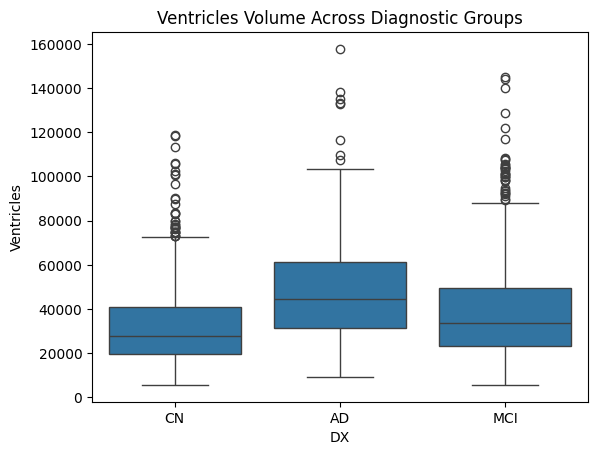

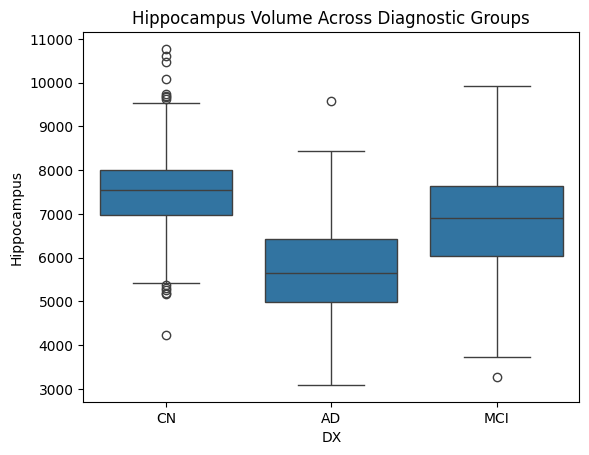

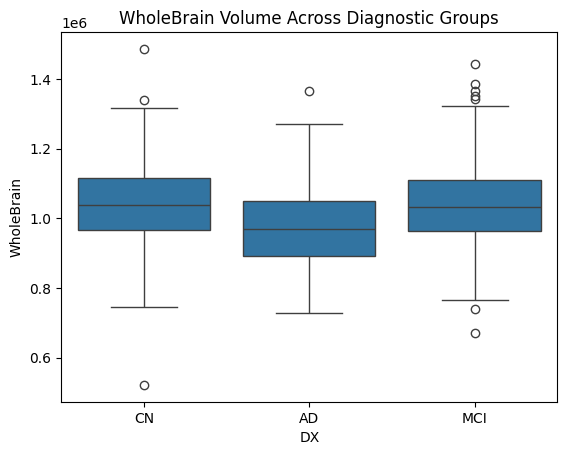

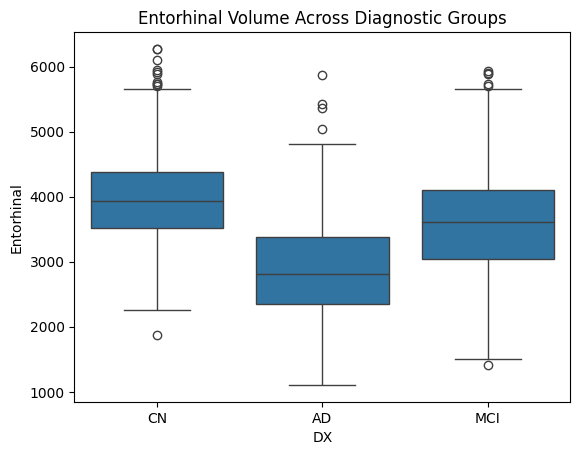

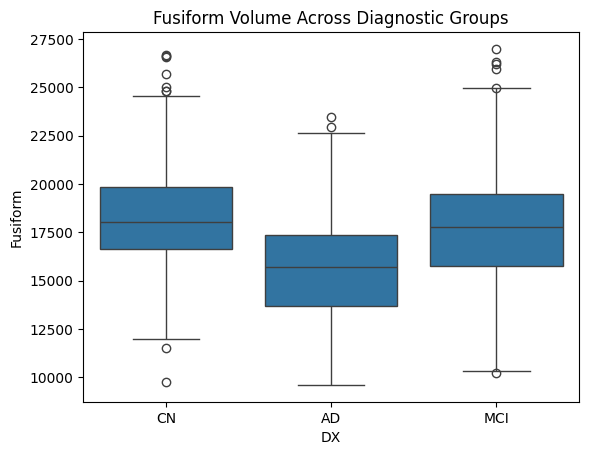

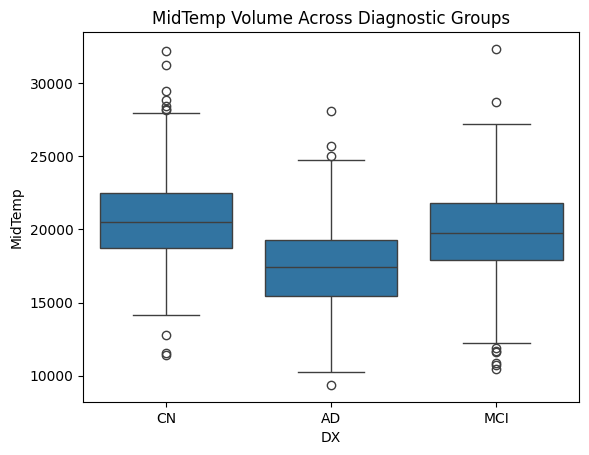

In [48]:
# Visualization of volume differences between groups
def visualize_volumes_for_all_regions(data):
    regions = ["Ventricles", "Hippocampus", "WholeBrain", "Entorhinal", "Fusiform", "MidTemp"]
    for region in regions:
        sns.boxplot(x='DX', y=region, data=data)
        plt.title(f'{region} Volume Across Diagnostic Groups')
        plt.show()

visualize_volumes_for_all_regions(grouped_data)

In [49]:
# Interaction effect analysis for all regions
def run_interaction_analysis_for_all_regions(data):
    regions = ["Ventricles", "Hippocampus", "WholeBrain", "Entorhinal", "Fusiform", "MidTemp"]
    for region in regions:
        formula = f'{region} ~ C(DX) * ICV + AGE + PTGENDER'
        model = ols(formula, data=data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f"Interaction effect analysis for {region} (C(DX) * ICV):\n", anova_table)

# Example: Running interaction analysis for all regions
run_interaction_analysis_for_all_regions(grouped_data)

Interaction effect analysis for Ventricles (C(DX) * ICV):
                  sum_sq      df           F         PR(>F)
C(DX)      3.048517e+10     2.0   55.039544   5.702675e-24
PTGENDER   3.927133e+06     1.0    0.014181   9.052229e-01
ICV        1.516477e+11     1.0  547.585725  9.152496e-107
C(DX):ICV  2.605769e+09     2.0    4.704593   9.158113e-03
AGE        7.660801e+10     1.0  276.624326   3.876551e-58
Residual   5.322764e+11  1922.0         NaN            NaN
Interaction effect analysis for Hippocampus (C(DX) * ICV):
                  sum_sq      df           F         PR(>F)
C(DX)      6.525722e+08     2.0  424.863083  1.599345e-153
PTGENDER   1.363832e+07     1.0   17.758710   2.623826e-05
ICV        7.970242e+07     1.0  103.781981   8.965427e-24
C(DX):ICV  9.757433e+06     2.0    6.352666   1.778898e-03
AGE        3.505687e+08     1.0  456.481951   4.790000e-91
Residual   1.476056e+09  1922.0         NaN            NaN
Interaction effect analysis for WholeBrain (C(DX) * ICV

# Longitudinal Analysis using Mixed Effect Model

In [50]:
df_longitudinal = df_adnimerge[df_adnimerge["COLPROT"] == "ADNI1"]
anatomical_structures_columns = ["RID", "PTID","VISCODE", "AGE", "PTGENDER", "DX"] + base_volumetric_columns
df_longitudinal = df_longitudinal[anatomical_structures_columns]

# Drop rows with missing volumetric data
df_longitudinal = df_longitudinal.dropna(subset=base_volumetric_columns)

# Function to filter the dataset for subjects with a minimum number of visits
def filter_minimum_visits(data, min_visits=3):
    # Count the number of unique visits (VISCODE) for each subject (RID)
    visit_counts = data.groupby('RID')['VISCODE'].nunique()  # Count unique visits for each subject
    
    # Get the RIDs of subjects with at least 'min_visits' visits
    min_visits_rid = visit_counts[visit_counts >= min_visits].index  
    
    # Filter the dataset to only include subjects with at least 'min_visits' visits
    filtered_data = data[data['RID'].isin(min_visits_rid)]
    
    return filtered_data

# Filter subjects with at least 3 visits
filtered_grouped_data = filter_minimum_visits(df_longitudinal, min_visits=3)


In [51]:
# Longitudinal analysis for all regions
def longitudinal_analysis_for_all_regions(data):
    regions = ["Ventricles", "Hippocampus", "WholeBrain", "Entorhinal", "Fusiform", "MidTemp"]
    for region in regions:
        model = smf.mixedlm(f"{region} ~ C(DX) + ICV + AGE + PTGENDER", data=data, groups=data["RID"])
        result = model.fit()
        print(result.summary())


longitudinal_analysis_for_all_regions(df_longitudinal)

                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Ventricles   
No. Observations:       2818          Method:                   REML         
No. Groups:             769           Scale:                    12501117.3972
Min. group size:        1             Log-Likelihood:           -28731.1663  
Max. group size:        7             Converged:                Yes          
Mean group size:        3.7                                                  
-----------------------------------------------------------------------------
                     Coef.     Std.Err.    z    P>|z|    [0.025      0.975]  
-----------------------------------------------------------------------------
Intercept          -135607.453 9849.749 -13.768 0.000 -154912.606 -116302.299
C(DX)[T.CN]         -10001.067  711.227 -14.062 0.000  -11395.046   -8607.089
C(DX)[T.MCI]         -7598.054  308.617 -24.620 0.000   -8202.932   -6993.176
PTGEND